# Predict_4 港区関数＋Lightgbm

## おまじない

In [331]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import re
import lightgbm as lgb

## データの読み込み
- train.csvとtest.csvとsample.csvの３つのファイルを読み込みましょう
- それぞれを読み込んだものは変数はtrain, test, sampleに代入しましょう
- sampleを読み込む時は、header=Noneというオプションを忘れないようにしましょう

In [332]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submit.csv", header = None )

In [301]:
train.head()

,id,賃料,所在地,アクセス,間取り,築年数,方角,面積,所在階,バス・トイレ,キッチン,放送・通信,室内設備,駐車場,周辺環境,建物構造,契約期間
0,1,75000,東京都北区滝野川３丁目,都営三田線\t西巣鴨駅\t徒歩4分\t\t埼京線\t板橋駅\t徒歩14分\t\t都電荒川線\...,1K,9年9ヶ月,南東,20.01m2,1階／12階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有,【小学校】 495m\t【大学】 461m\t【小学校】 962m\t【公園】 1103m\...,RC（鉄筋コンクリート）,2年間
1,2,76000,東京都中央区月島３丁目,都営大江戸線\t勝どき駅\t徒歩5分\t\t有楽町線\t月島駅\t徒歩9分\t\t日比谷線\...,1R,44年10ヶ月,NaN,16.5m2,5階／10階建,専用トイレ／\tシャワー／\t温水洗浄便座,ガスコンロ／\tシステムキッチン\t／\t給湯,インターネット対応,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\t駐車場\t無\tバイク置き場\t無,【スーパー】 1283m,鉄骨造,2年間
2,3,110000,東京都渋谷区笹塚２丁目,京王線\t笹塚駅\t徒歩6分\t\t京王線\t代田橋駅\t徒歩7分\t\t京王線\t明大前駅...,1K,8年6ヶ月,南,22.05m2,12階／15階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t光ファイバー／\tCSアンテナ／\tBSアンテナ,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,"駐輪場\t空有\tバイク置き場\t空有\t駐車場\t近隣\t30,000円(税込)\t距離100m",【スーパー】 89m\t【コンビニ】 184m\t【コンビニ】 392m\t【スーパー】 492m,RC（鉄筋コンクリート）,2年間
3,4,150000,東京都杉並区高円寺南２丁目23-2,総武線・中央線（各停）\t高円寺駅\t徒歩9分\t\t丸ノ内線(池袋－荻窪)\t新高円寺駅\...,2LDK,29年4ヶ月,南,60.48m2,3階／4階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t温水洗浄便座／\t洗面台独立,ガスコンロ／\t給湯,インターネット対応／\t光ファイバー,エアコン付\tシューズボックス／\tバルコニー／\t2面採光／\t室内洗濯機置場／\tエレベ...,駐車場\t無\t駐輪場\t無\tバイク置き場\t無,【スーパー】 225m\t【スーパー】 448m\t【スーパー】 619m\t【スーパー】 ...,RC（鉄筋コンクリート）,2年間\t※この物件は\t定期借家\tです。
4,5,74000,東京都葛飾区金町３丁目7-2,京成金町線\t京成金町駅\t徒歩5分\t\t常磐線\t金町(東京都)駅\t徒歩7分\t\t京...,2DK,31年7ヶ月,南,39.66m2,1階／2階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t追焚機能,給湯／\t独立キッチン,NaN,バルコニー／\tフローリング／\t室内洗濯機置場\t公営水道／\t下水,"駐車場\t近隣\t17,000円(税込)\t距離300m\t駐輪場\t無\tバイク置き場\t無",【スーパー】 193m\t【スーパー】 298m\t【スーパー】 660m\t【スーパー】 ...,木造,2年間


In [302]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31470 entries, 0 to 31469
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31470 non-null  int64 
 1   賃料      31470 non-null  int64 
 2   所在地     31470 non-null  object
 3   アクセス    31470 non-null  object
 4   間取り     31470 non-null  object
 5   築年数     31470 non-null  object
 6   方角      28721 non-null  object
 7   面積      31470 non-null  object
 8   所在階     31470 non-null  object
 9   バス・トイレ  31141 non-null  object
 10  キッチン    30849 non-null  object
 11  放送・通信   28030 non-null  object
 12  室内設備    31388 non-null  object
 13  駐車場     26183 non-null  object
 14  周辺環境    22038 non-null  object
 15  建物構造    31470 non-null  object
 16  契約期間    24350 non-null  object
dtypes: int64(2), object(15)
memory usage: 4.1+ MB


In [333]:
train['築年数'].apply(lambda x :x.split('年')[0]).unique()

array(['9', '44', '8', '29', '31', '7', '10', '14', '38', '4', '59', '0',
       '40', '23', '5', '6', '37', '28', '30', '52', '2', '1', '16', '13',
       '21', '50', '12', '11', '26', '41', '34', '51', '53', '24', '17',
       '27', '新築', '25', '62', '32', '39', '36', '18', '49', '35', '15',
       '3', '19', '45', '20', '33', '42', '46', '43', '48', '22', '54',
       '47', '58', '57', '56', '61', '64', '55', '63', '60', '69', '68',
       '79', '65', '520', '1019', '119', '70', '66'], dtype=object)

In [379]:
def TrainX_generator(train):
    ##空欄埋め
    train = train.fillna('なし')
    
    ##引数（Train)からtrainXの箱作成
    trainX = train[['id','契約期間','賃料']]
    
    ##区
    trainX['区'] = train["所在地"].apply(lambda x: re.findall(r"東京都(.*区)", x)[0])
   
    ##港区
    def minato(x):
        if '港区' in x:
            return 1
        else:
            return 0
    trainX['港'] = train['所在地'].apply(lambda x :minato(x))
    
    ##間取り
    Train_Madori = train['間取り']
    def Naya(x):
        if '+' in x:
            xnew = x.split('+')[0]
            return xnew
    
        else:
            return x
     
    trainX['間取り']= train['間取り'].apply(lambda x :Naya(x))

    ##納屋
    def Naya1(x):
        if '+' in x:
            return 1
        else:
            return 0
    trainX['納屋'] = train['間取り'].apply(lambda x :Naya1(x))    
    
    ##面積
    trainX['面積'] = train['面積'].apply(lambda x :x.split('m')[0]).astype(float)
    
    ##築年数
    def Chikunen(x):
        if '新築' in x:
            return 1
        else:
            Chikunen = x.split('年')[0]
            return Chikunen
    
    trainX['築年数']=train['築年数'].apply(lambda x :Chikunen(x))
    trainX['築年数']=pd.to_numeric(trainX['築年数'])
    
    ##階数
    def syozaikai(x):
        if '／' in x:
            return x.split("／")[0]
    
        else:
            return x
    def tx_float2(x):
        return re.sub(r"\D", "",x)

    trainX["階数"] = train["所在階"].apply(lambda x :syozaikai(x)).apply(lambda x :tx_float2(x))
    trainX['階数']=pd.to_numeric(trainX['階数'])
    
    ##バス、徒歩、車
    def bus(x):
        if 'バス' in x:
            x=1
            return 1
        else:
            X=0
            return X
        
    def walk(x):
        if '徒歩' in x:
            x=1
            return 1
        else:
            X=0
            return X
    
    def car(x):
        if '車' in x:
            x=1
            return 1
        else:
            X=0
            return X
    trainX["徒歩"] = train["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :walk(x))
    trainX["バス"] = train["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :bus(x))
    trainX["車"] = train["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :car(x))
    
    ##徒歩時間
    def total_time(x):
        if 'バス(' in x.split("\t")[2]:
            if '徒歩' in x.split("\t")[2]:
                time1 =  int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0])) + int(re.sub(r'\D', '', x.split("\t")[2].split(')')[1].split('歩')[1]))
                return time1
            elif '車' in x.split("\t")[2]:
                time2 = int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0]))
                return time2
            else:       
                time3 = int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0]))
                return time3
        
        elif '車' in x.split("\t")[2]:
            time4 = int(re.sub(r'\D', '', x.split("\t")[2].split('(')[1]))
            return time4
        else:
            time5 = int(re.sub(r'\D', '', x.split("\t")[2]))
            return time5
    
    trainX["徒歩時間"] = train["アクセス"].apply(lambda x :total_time(x))
    
    ##最寄駅
    trainX["最寄駅"] = train["アクセス"].apply(lambda x :x.split("\t")[1])
    
    ##木造とそれ以外
    def kouzou(x):
        if '木造' in x:
            return 1
        else:
            return 0
    trainX['構造'] = train['建物構造'].apply(lambda x :kouzou(x))
    
    ##システムキッチン、独立キッチン
    def system_kittin(x):
        if 'システムキッチン' in x:
            return 1
        else:
            return 0
    
    def dokuritsu_kittin(x):
        if '独立キッチン' in x:
            return 1
        else:
            return 0
    trainX['システムキッチン'] = train['キッチン'].apply(lambda x :system_kittin(x))
    trainX['独立キッチン'] = train['キッチン'].apply(lambda x :dokuritsu_kittin(x))
    
    trainX = trainX.drop('契約期間',axis=1).drop('id',axis=1)
    
    return trainX

In [380]:
TrainX = TrainX_generator(train)
TrainX

/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/705442332.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX['区'] = train["所在地"].apply(lambda x: re.findall(r"東京都(.*区)", x)[0])
/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/705442332.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainX['港'] = train['所在地'].apply(lambda x :minato(x))
/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/705442332.py:29: SettingWithCopyWarning: 
A value is trying to b

,賃料,区,港,間取り,納屋,面積,築年数,階数,徒歩,バス,車,徒歩時間,最寄駅,構造,システムキッチン,独立キッチン
0,75000,北区,0,1K,0,20.01,9,1.0,1,0,0,4,西巣鴨駅,0,1,0
1,76000,中央区,0,1R,0,16.50,44,5.0,1,0,0,5,勝どき駅,0,1,0
2,110000,渋谷区,0,1K,0,22.05,8,12.0,1,0,0,6,笹塚駅,0,1,0
3,150000,杉並区,0,2LDK,0,60.48,29,3.0,1,0,0,9,高円寺駅,0,0,0
4,74000,葛飾区,0,2DK,0,39.66,31,1.0,1,0,0,5,京成金町駅,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31465,80000,板橋区,0,2DK,0,37.90,30,1.0,1,0,0,7,蓮根駅,0,0,0
31466,54500,世田谷区,0,1R,0,12.04,39,4.0,1,0,0,6,三軒茶屋駅,0,0,0
31467,125000,江東区,0,3DK,0,60.00,45,3.0,1,0,0,5,南砂町駅,0,0,0
31468,98000,中野区,0,1DK,0,29.59,11,1.0,1,0,0,4,中野(東京都)駅,1,1,0


## trainからyを取り出し、変数yに代入しましょう

In [336]:
y = train['賃料']

In [381]:
def TestX_generator(test):
    ##空欄埋め
    test = test.fillna('なし')
    
    ##引数（Train)からtrainXの箱作成
    testX = test[['id','契約期間']]

    ##区
    testX['区'] = test["所在地"].apply(lambda x: re.findall(r"東京都(.*区)", x)[0])

    ##港区関数
    def minato(x):
        if '港区' in x:
            return 1
        else:
            return 0
    testX['港'] = test['所在地'].apply(lambda x :minato(x))

    ##間取り
    Train_Madori = test['間取り']
    def Naya(x):
        if '+' in x:
            xnew = x.split('+')[0]
            return xnew
    
        else:
            return x
     
    testX['間取り']= test['間取り'].apply(lambda x :Naya(x))

    
    ##納屋
    def Naya1(x):
        if '+' in x:
            return 1
        else:
            return 0
    testX['納屋'] = test['間取り'].apply(lambda x :Naya1(x))

    
    ##面積
    testX['面積'] = test['面積'].apply(lambda x :x.split('m')[0]).astype(float)

    
    ##築年数
    def Chikunen(x):
        if '新築' in x:
            return 1
        else:
            Chikunen = x.split('年')[0]
            return Chikunen
    
    testX['築年数']=test['築年数'].apply(lambda x :Chikunen(x))
    testX['築年数']=pd.to_numeric(testX['築年数'])
    
    ##階数
    def syozaikai(x):
        if '／' in x:
            return x.split("／")[0]
    
        else:
            return x
        
    def tx_float2(x):
        return re.sub(r"\D", "",x)

    testX["階数"] = test["所在階"].apply(lambda x :syozaikai(x)).apply(lambda x :tx_float2(x))
    testX['階数']=pd.to_numeric(testX['階数'])
    ##バス、徒歩、車
    def bus(x):
        if 'バス' in x:
            x=1
            return 1
        else:
            X=0
            return X
        
    def walk(x):
        if '徒歩' in x:
            x=1
            return 1
        else:
            X=0
            return X
    
    def car(x):
        if '車' in x:
            x=1
            return 1
        else:
            X=0
            return X
    testX["徒歩"] = test["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :walk(x))
    testX["バス"] = test["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :bus(x))
    testX["車"] = test["アクセス"].apply(lambda x :x.split("\t")[2]).apply(lambda x :car(x))
    
    ##徒歩時間
    def total_time(x):
        if 'バス(' in x.split("\t")[2]:
            if '徒歩' in x.split("\t")[2]:
                time1 =  int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0])) + int(re.sub(r'\D', '', x.split("\t")[2].split(')')[1].split('歩')[1]))
                return time1
            elif '車' in x.split("\t")[2]:
                time2 = int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0]))
                return time2
            else:       
                time3 = int(re.sub(r'\D', '', x.split("\t")[2].split(')')[0]))
                return time3
        
        elif '車' in x.split("\t")[2]:
            time4 = int(re.sub(r'\D', '', x.split("\t")[2].split('(')[1]))
            return time4
        else:
            time5 = int(re.sub(r'\D', '', x.split("\t")[2]))
            return time5
    
    testX["徒歩時間"] = test["アクセス"].apply(lambda x :total_time(x))
    
    ##最寄駅
    testX["最寄駅"] = test["アクセス"].apply(lambda x :x.split("\t")[1])
    
    ##木造とそれ以外
    def kouzou(x):
        if '木造' in x:
            return 1
        else:
            return 0
    testX['構造'] = test['建物構造'].apply(lambda x :kouzou(x))
    
    ##システムキッチン、独立キッチン
    def system_kittin(x):
        if 'システムキッチン' in x:
            return 1
        else:
            return 0
    
    def dokuritsu_kittin(x):
        if '独立キッチン' in x:
            return 1
        else:
            return 0
    testX['システムキッチン'] = test['キッチン'].apply(lambda x :system_kittin(x))
    testX['独立キッチン'] = test['キッチン'].apply(lambda x :dokuritsu_kittin(x))
       
    
    testX = testX.drop('契約期間',axis=1).drop('id',axis=1)
    
    return testX

In [382]:
TestX = TestX_generator(test)
TestX

/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/2243940171.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testX['区'] = test["所在地"].apply(lambda x: re.findall(r"東京都(.*区)", x)[0])
/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/2243940171.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testX['港'] = test['所在地'].apply(lambda x :minato(x))
/var/folders/c5/qpcjx9ws0z9_ftm09hc6j7wh0000gn/T/ipykernel_53701/2243940171.py:29: SettingWithCopyWarning: 
A value is trying to be

,区,港,間取り,納屋,面積,築年数,階数,徒歩,バス,車,徒歩時間,最寄駅,構造,システムキッチン,独立キッチン
0,世田谷区,0,2LDK,0,50.22,49,8.0,1,0,0,15,等々力駅,0,1,0
1,目黒区,0,1R,0,20.88,0,3.0,1,0,0,6,都立大学駅,0,1,0
2,豊島区,0,1K,0,26.93,23,1.0,1,0,0,10,北池袋駅,0,0,0
3,杉並区,0,1K,0,23.57,36,1.0,1,0,0,10,方南町駅,1,0,0
4,杉並区,0,2LDK,0,50.00,45,4.0,1,0,0,12,方南町駅,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,豊島区,0,1K,0,25.66,0,6.0,1,0,0,3,板橋駅,0,1,0
31258,千代田区,0,1R,0,22.71,15,8.0,1,0,0,2,岩本町駅,0,1,1
31259,中野区,0,1LDK,0,45.76,1,10.0,1,0,0,10,新江古田駅,0,0,0
31260,千代田区,0,1K,0,55.20,15,14.0,1,0,0,3,麹町駅,0,1,1


## 質的変数　統一

In [284]:
TrainX.fillna('不明')
TestX.fillna('不明')

,区,港,間取り,納屋,面積,方角,築年数,階数,徒歩,バス,車,徒歩時間,最寄駅,構造,システムキッチン,独立キッチン
0,世田谷区,0,2LDK,0,50.22,南東,49,8.0,1,0,0,15,等々力駅,0,1,0
1,目黒区,0,1R,0,20.88,不明,0,3.0,1,0,0,6,都立大学駅,0,1,0
2,豊島区,0,1K,0,26.93,南,23,1.0,1,0,0,10,北池袋駅,0,0,0
3,杉並区,0,1K,0,23.57,南,36,1.0,1,0,0,10,方南町駅,1,0,0
4,杉並区,0,2LDK,0,50.00,南,45,4.0,1,0,0,12,方南町駅,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,豊島区,0,1K,0,25.66,南,0,6.0,1,0,0,3,板橋駅,0,1,0
31258,千代田区,0,1R,0,22.71,南東,15,8.0,1,0,0,2,岩本町駅,0,1,1
31259,中野区,0,1LDK,0,45.76,東,1,10.0,1,0,0,10,新江古田駅,0,0,0
31260,千代田区,0,1K,0,55.20,北西,15,14.0,1,0,0,3,麹町駅,0,1,1


In [309]:
TestX['間取り'] = pd.Categorical(TestX['間取り'],TrainX['間取り'].unique())
TestX['間取り']

0        2LDK
1          1R
2          1K
3          1K
4        2LDK
         ... 
31257      1K
31258      1R
31259    1LDK
31260      1K
31261      1K
Name: 間取り, Length: 31262, dtype: category
Categories (18, object): ['1K', '1R', '2LDK', '2DK', ..., '5DK', '5K', '6LDK', '1LK']

In [310]:
station_list = pd.concat([TrainX['最寄駅'],TestX['最寄駅']],axis='index').unique()

In [311]:
TestX['最寄駅'] = pd.Categorical(TestX['最寄駅'],station_list)
TestX['最寄駅']

0         等々力駅
1        都立大学駅
2         北池袋駅
3         方南町駅
4         方南町駅
         ...  
31257      板橋駅
31258     岩本町駅
31259    新江古田駅
31260      麹町駅
31261     西馬込駅
Name: 最寄駅, Length: 31262, dtype: category
Categories (476, object): ['西巣鴨駅', '勝どき駅', '笹塚駅', '高円寺駅', ..., '鶴瀬駅', '東尾久三丁目駅', '国際展示場駅', '武蔵小杉駅']

In [312]:
TrainX['最寄駅'] = pd.Categorical(TrainX['最寄駅'],station_list)
TrainX['最寄駅']

0            西巣鴨駅
1            勝どき駅
2             笹塚駅
3            高円寺駅
4           京成金町駅
           ...   
31465         蓮根駅
31466       三軒茶屋駅
31467        南砂町駅
31468    中野(東京都)駅
31469         千川駅
Name: 最寄駅, Length: 31470, dtype: category
Categories (476, object): ['西巣鴨駅', '勝どき駅', '笹塚駅', '高円寺駅', ..., '鶴瀬駅', '東尾久三丁目駅', '国際展示場駅', '武蔵小杉駅']

In [313]:
ku_list = pd.concat([TrainX['区'],TestX['区']],axis='index').unique()

In [314]:
TestX['区'] = pd.Categorical(TestX['区'],ku_list)
TrainX['区'] = pd.Categorical(TrainX['区'],ku_list)

0            西巣鴨駅
1            勝どき駅
2             笹塚駅
3            高円寺駅
4           京成金町駅
           ...   
31465         蓮根駅
31466       三軒茶屋駅
31467        南砂町駅
31468    中野(東京都)駅
31469         千川駅
Name: 最寄駅, Length: 31470, dtype: category
Categories (476, object): ['西巣鴨駅', '勝どき駅', '笹塚駅', '高円寺駅', ..., '鶴瀬駅', '東尾久三丁目駅', '国際展示場駅', '武蔵小杉駅']

## ダミー変数化

In [229]:
TrainX = pd.get_dummies(TrainX)
TestX = pd.get_dummies(TestX)

In [230]:
len(TrainX.columns)

530

In [231]:
len(TestX.columns)

529

## カテゴリー化

In [383]:
lbl = LabelEncoder()
categorical_features = TrainX.select_dtypes(object).columns.to_list()
categorical_features

['区', '間取り', '最寄駅']

In [384]:
for categorical_feature in categorical_features:
    TrainX[categorical_feature] = lbl.fit_transform(TrainX[categorical_feature])
    TestX[categorical_feature] = lbl.fit_transform(TestX[categorical_feature])

## データの分割

In [385]:
##一旦数値データのみ
TrainX

,賃料,区,港,間取り,納屋,面積,築年数,階数,徒歩,バス,車,徒歩時間,最寄駅,構造,システムキッチン,独立キッチン
0,75000,3,0,1,0,20.01,9,1.0,1,0,0,4,391,0,1,0
1,76000,1,0,4,0,16.50,44,5.0,1,0,0,5,87,0,1,0
2,110000,15,0,1,0,22.05,8,12.0,1,0,0,6,344,0,1,0
3,150000,11,0,7,0,60.48,29,3.0,1,0,0,9,451,0,0,0
4,74000,20,0,5,0,39.66,31,1.0,1,0,0,5,60,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31465,80000,12,0,5,0,37.90,30,1.0,1,0,0,7,379,0,0,0
31466,54500,0,0,4,0,12.04,39,4.0,1,0,0,6,10,0,0,0
31467,125000,14,0,8,0,60.00,45,3.0,1,0,0,5,107,0,0,0
31468,98000,2,0,0,0,29.59,11,1.0,1,0,0,4,39,1,1,0


In [386]:
TestX

,区,港,間取り,納屋,面積,築年数,階数,徒歩,バス,車,徒歩時間,最寄駅,構造,システムキッチン,独立キッチン
0,0,0,8,0,50.22,49,8.0,1,0,0,15,348,0,1,0
1,17,0,5,0,20.88,0,3.0,1,0,0,6,426,0,1,0
2,21,0,2,0,26.93,23,1.0,1,0,0,10,90,0,0,0
3,11,0,2,0,23.57,36,1.0,1,0,0,10,213,1,0,0
4,11,0,8,0,50.00,45,4.0,1,0,0,12,213,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,21,0,2,0,25.66,0,6.0,1,0,0,3,260,0,1,0
31258,4,0,5,0,22.71,15,8.0,1,0,0,2,163,0,1,1
31259,2,0,3,0,45.76,1,10.0,1,0,0,10,208,0,0,0
31260,4,0,2,0,55.20,15,14.0,1,0,0,3,464,0,1,1


In [387]:
TestX.columns

Index(['区', '港', '間取り', '納屋', '面積', '築年数', '階数', '徒歩', 'バス', '車', '徒歩時間',
       '最寄駅', '構造', 'システムキッチン', '独立キッチン'],
      dtype='object')

In [388]:
#一度にトレーングデータとテストデータを処理するため、一時結合（後で再度分割するため、ソートはしないこと）
data=pd.concat([TrainX,TestX],sort=False)

In [389]:
#トレーニングデータとテストデータの分割
TrainX_feat=data[:len(TrainX)]#train_df分の長さまで
TestX_feat=data[-len(TestX):]#後ろから数えてtest_df分の長さを取り出し

In [390]:
#学習に使う列。数値しかない列を抽出(このように定義しておくと列の追加、削除が楽になる)
features = TestX.columns
target = ['賃料']

In [391]:
x_train = TrainX_feat[features].values #train.csvの特徴量
y_train = TrainX_feat[target].values #train.csvの目的変数price
x_test = TestX_feat[features].values #test.csvの特徴量

## LightGBMの実装

In [392]:
#lgb用のデータセットを作成（これを使用すると処理速度が早いらしい）
train_dataset=lgb.Dataset(x_train, y_train)#トレーニング用のデータセット作成

#lightGBMに必要な設定らしい
params={
    "objective":"regression_l1"}
lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=categorical_features)

In [393]:
#トレーニングデータからモデルを作成
model=lgb.train(params,train_dataset)

#終了確認
print("========================done!========================")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 31470, number of used features: 14
[LightGBM] [Info] Start training from score 102000.000000
========================done!========================


/Users/tozawahiroya/opt/anaconda3/envs/tech0_deta_Analisis/lib/python3.9/site-packages/lightgbm/basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [394]:
#テストデータを用いて価格の予測を実行
y_test= model.predict(x_test)

#終了確認
print("========================done!========================")

========================done!========================


## TrainXでの評価

In [395]:
y_valid= model.predict(x_train)

In [396]:
score = np.sqrt(mean_squared_error(y, y_valid))

In [397]:
valid_df = pd.DataFrame({"prod": y, "prediction": y_valid})

total score (rsme): 30120.657451304505


<AxesSubplot:xlabel='prod', ylabel='prediction'>

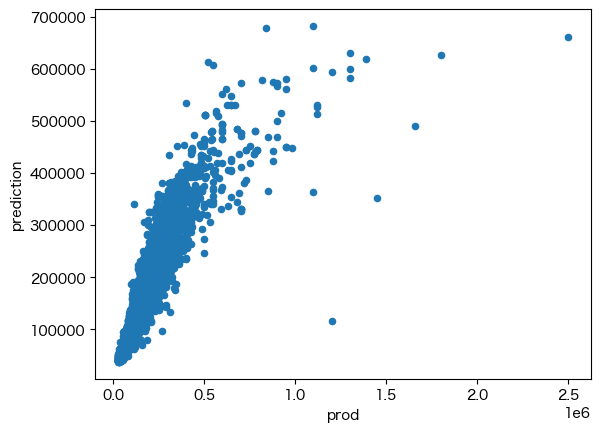

In [398]:
print(f"total score (rsme): {score}")
valid_df.plot(x="prod", y="prediction", kind="scatter")

## sample[1]に予測結果を代入しましょう

In [399]:
sample[1] = y_test
sample

,0,1
0,31471,143396.738525
1,31472,114872.172167
2,31473,82433.316989
3,31474,60104.262325
4,31475,118958.451552
...,...,...
31257,62728,113160.355752
31258,62729,106719.072058
31259,62730,171907.531855
31260,62731,235290.507093


## sampleを"submit2.csv"というファイルで出力して、DeepAnalyticsに投稿しましょう

In [400]:
sample.to_csv("submit_6+カテゴリ.csv", index=None, header=None)